In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os

import numpy as np
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

import matplotlib.pyplot as plt

import sys
sys.path.append('..')
from src.saliency_score_computation import MCQs_saliency_score_computation

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
celebrities_info = []
with open('./data/thinking_bias/celebrities.json', 'r') as f:
    celebrities_info = json.load(f)

model_path = "/path/to/your/Llama-2-7B-chat"
model_name = "Llama-2-7B"

# model_path = "/path/to/your/Llama-2-13B-chat"
# model_name = "Llama-2-13B"

In [4]:
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
    trust_remote_code=True,
    device_map="auto",
    # For the ease of activation acquirement
    attn_implementation="eager"
)

model.eval()

tokenizer = AutoTokenizer.from_pretrained(
    model_path,
    trust_remote_code=True
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:46<00:00, 23.38s/it]


In [ ]:
n2d_scores, d2n_scores = MCQs_saliency_score_computation(model, tokenizer, celebrities_info)

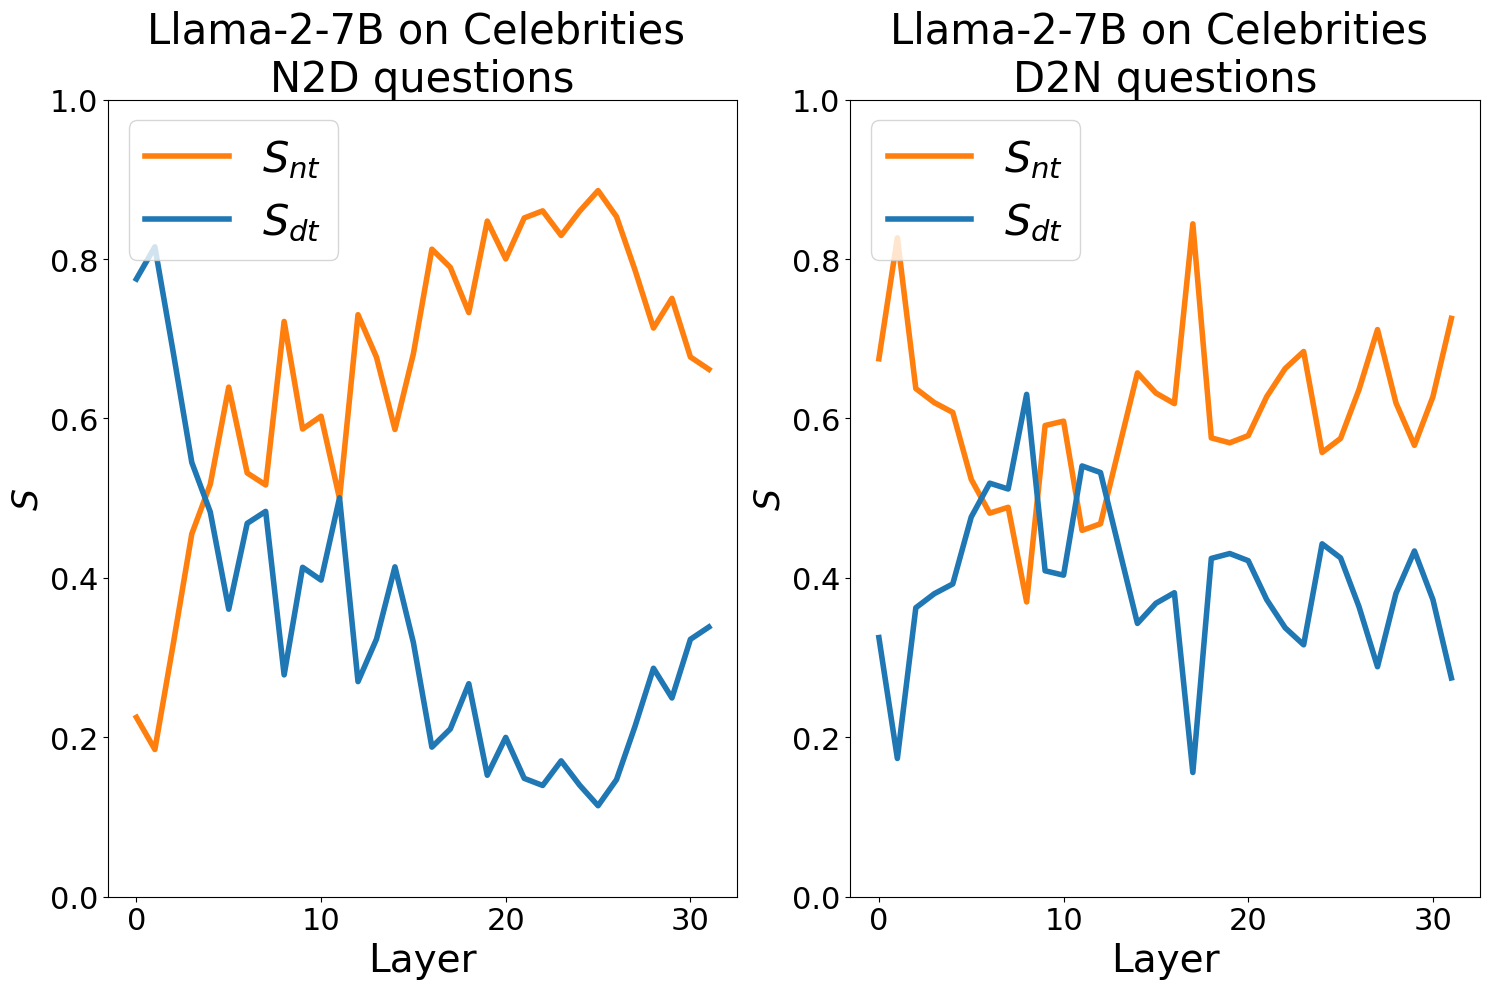

In [6]:
plt.figure(figsize=(15, 10))

for i, scores in enumerate([n2d_scores, d2n_scores]):
    plt.subplot(1, 2, i+1)

    question_type = ["N2D", "D2N"][i]

    plt.title(f"{model_name} on Celebrities \n{question_type} questions", fontsize=30)
    plot_curves = np.stack(scores)
    mean_curves = np.mean(plot_curves, axis=0)

    if question_type == "D2N":
        mean_curves = mean_curves[[1, 0]]
    
    labels = [r"$S_{nt}$", r"$S_{dt}$"]

    for c, l, color in zip(mean_curves, labels, ['C1', 'C0']):
        plt.plot(c, label=l, linewidth=4, color=color)
    
    plt.yticks(np.arange(0, 1.1, 0.2))
    plt.legend(loc="upper left", fontsize=30)
    plt.tick_params(labelsize=22)
    plt.xlabel("Layer", fontsize=28)
    plt.ylabel(r"$S$", fontsize=25)

plt.tight_layout()
plt.show()